In [1]:
#Packages
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


## Load and Manipulate Data

### Load the data

In [2]:
#Load the census data
census_dat = pd.read_csv('./data/Census_Data_Cleaned.csv', dtype = 'str')

#Load the hospital beds data
beds_dat = pd.read_csv('./data/hospital_beds_data.csv', dtype = 'str')

#Load the cases data
cases_nyc = pd.read_csv('./zcta-history/2020-04-01.csv', dtype = 'str')

cases_nyc_0409 = pd.read_csv('./zcta-history/2020-04-09.csv', dtype = 'str')
cases_nyc_0414 = pd.read_csv('./zcta-history/2020-04-14.csv', dtype = 'str')
cases_nyc_0421 = pd.read_csv('./zcta-history/2020-04-21.csv', dtype = 'str')
cases_nyc_0428 = pd.read_csv('./zcta-history/2020-04-28.csv', dtype = 'str')

### Combine and Manipulate the data

In [3]:
cases_nyc = cases_nyc.rename(columns={"Positive": "Positive_0401", "Total": "Total_0401", 
                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0401"})

cases_nyc_0409 = cases_nyc_0409.rename(columns={"Positive": "Positive_0409", "Total": "Total_0409", 
                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0409"})

cases_nyc_0414 = cases_nyc_0414.rename(columns={"Positive": "Positive_0414", "Total": "Total_0414", 
                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0414"})

cases_nyc_0421 = cases_nyc_0421.rename(columns={"Positive": "Positive_0421", "Total": "Total_0421", 
                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0421"})

cases_nyc_0428 = cases_nyc_0428.rename(columns={"Positive": "Positive_0428", "Total": "Total_0428", 
                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0428"})

In [4]:
#Join together all the weekly cases data
cases_nyc = cases_nyc.merge(cases_nyc_0409, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')
cases_nyc = cases_nyc.merge(cases_nyc_0414, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')
cases_nyc = cases_nyc.merge(cases_nyc_0421, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')
cases_nyc = cases_nyc.merge(cases_nyc_0428, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')

In [5]:
#Join all the values together
data = cases_nyc.merge(census_dat, how = 'left', left_on = 'MODZCTA', right_on = 'zip_code_tabulation_area')
data = data.merge(beds_dat, how = 'left', left_on = 'MODZCTA', right_on = 'zip')

data["beds"] = data["beds"].fillna(0)

In [6]:
#Remove the first record (no zip)
data = data[1:]

#Remove the zip code columns
data = data.loc[:, data.columns != 'zip_code_tabulation_area']
data = data.loc[:, data.columns != 'zip']

In [7]:
data.head()

,MODZCTA,Positive_0401,Total_0401,Positive_0409,Total_0409,zcta_cum_perc_pos_0409,Positive_0414,Total_0414,zcta_cum_perc_pos_0414,Positive_0421,...,perc_transportation_warehousing,perc_utilites,perc_information,perc_finance,perc_scientific,perc_education_healthcare,perc_arts_entertainment,perc_otherservices,perc_publicadministration,beds
1,10001,113,265,191,408,46.81,231,480,48.12,266,...,0.06072874493927125,0.005398110661268556,0.018893387314439947,0.020242914979757085,0.037786774628879895,0.19163292847503374,0.017543859649122806,0.018893387314439947,0.04588394062078273,0
2,10002,250,542,456,889,51.29,578,1094,52.83,729,...,0,0,0,0,0,0.3333333333333333,0,0,0,0
3,10003,161,379,253,597,42.38,290,692,41.91,355,...,0.050100200400801605,0.008016032064128256,0.022044088176352707,0.04008016032064128,0.08817635270541083,0.12625250501002003,0.036072144288577156,0.026052104208416832,0.052104208416833664,501
4,10004,16,38,21,48,43.75,23,59,38.98,26,...,0,0,0,0,0.3125,0,0,0,0,0
5,10005,25,81,36,108,33.33,40,122,32.79,44,...,0.05041246562786435,0.00458295142071494,0.01833180568285976,0.03299725022914757,0.035747021081576534,0.15673693858845097,0.09624197983501374,0.03941338221814849,0.04857928505957837,0


In [8]:
#Cast the rest of the columns as float
for col in data.columns:
    if col == "MODZCTA":
        continue 
    else:
        data.loc[:,col] = data.loc[:,col].astype(float)
        
#Divide by 100 for percents
# data.loc[:,"zcta_cum_perc_pos_0401"] = data.loc[:,"zcta_cum_perc_pos_0401"]/100.0
data.loc[:,"zcta_cum_perc_pos_0409"] = data.loc[:,"zcta_cum_perc_pos_0409"]/100.0
data.loc[:,"zcta_cum_perc_pos_0414"] = data.loc[:,"zcta_cum_perc_pos_0414"]/100.0
data.loc[:,"zcta_cum_perc_pos_0421"] = data.loc[:,"zcta_cum_perc_pos_0421"]/100.0
data.loc[:,"zcta_cum_perc_pos_0428"] = data.loc[:,"zcta_cum_perc_pos_0428"]/100.0



In [9]:
#data = data.rename(columns={'median_house_income':'Median Household Income', 'housing_units':'Housing Units', 'med_age':'Median Age','pop_perc_white': 'Percent of Population White', 'pop_perc_black':'Percent of Popuation Black', 'pop_perc_indian_alaskan':'Percent of Population Indian Alaskan','pop_per_asian':'Percent of Population Asian','pop_perc_all_other':'Percent of Population Other Race',  'pop_perc_under_hs':'Percent of Population under High School Education', 'pop_perc_hs':'Percent of Population with High School Education', 'pop_perc_some_college':'Perent of Population with Some College Education','pop_perc_bachelor':'Percent of Population with Bachelors Degree', 'pop_perc_masters_above':'Percent of Population with Masters Degree or Higher', 'perc_us_citizen':'Percent of Population US Citizens', 'perc_transport_to_work_car':'Percent of Population Transporting to Work in Car', 'perc_transport_to_work_public':'Percent of Population Transporting to work in Public Transit', 'perc_transport_to_work_bike':'Percent of Population Transporting to Work on Bike','perc_transport_to_work_walk': 'Percent of Population that Walks to Work','perc_transport_to_work_taxi': 'Percent of Population that Transports to work via Taxi','perc_transport_to_work_workathome':'Percent of Population that Works at Home','perc_work_in_state_of_residence':'Percent of Population that Works in State of Residence','perc_with_Supplemental_Security_Income_cash_public_assistance_income_or_Food_Stamps_SNAP':'Percent of Population on Supplemental Security Income or Food Stamps','perc_married_family':'Percent of Population Married with Family','perc_now_married':'Percent of Population currently married', 'perc_never_married':'Percent of Population Never Married','perc_nonfamily':'Percent of Population with no Family', 'perc_separated':'Percent of Population Separated from S.O.', 'per_widowed':'Percent of Population Widowed', 'perc_divorced':'Percent of Population Divorced','perc_hadbaby_pastyear_married':'Percent of Population that had baby in Past Year (married)','perc_hadbaby_pastyear_unmarried':'Percent of Population that had baby in past year (unmarried)','weighted_avg_income_to_poverty_ratio':'Weighted Average of Income to Poverty Ratio', 'avg_travel_time_to_work_minutes':'Average Time to Travel to Work','avg_number_vehicles_count':"Average Number of Vechicles",'perc_wage_salary':"Percent of Population on Wage Salary",'perc_selfemployed':'Percent of Population Self Employed','perc_socialsecurity_income': 'Percent of Population on Social Security Income', 'perc_SSI':'Percent of Population on SSI','perc_publicassist_income':'Percent of Population on Public Assistance Income','perc_foodstamps':'Percent of Population on Food Stamps', 'perc_retirement_income':'Percent of Population on Retirement Income','med_numberrooms':'Median Number of Rooms in Home','med_yearbuilt':'Median Year Home Built','perc_withmortgage':'Percent of Population with Mortgage','med_monthlyhousingcost':'Median Monthly Housing Cost', 'perc_onlyenglish':'Percent of Population only speaking English','perc_agriculture':'Percent of Population in Agriculture Industry', 'perc_construction':'Percent of Population in Construction Industry','perc_manufacturing':'Percent of Population in Manufacturing Industry','perc_wholesaletrade':'Percent of Population in Wholesale Trade','perc_retailtrade':'Perecent of Population in Retail Trade','perc_transportation_warehousing':'Percent of Population in Transportation Warehousing','perc_utilites':'Percent of Population in Utilites','perc_information':'Perecent of Population in Information Sciences', 'perc_finance':'Percent of Population in Finance Industry', 'perc_scientific':'Percent of Population in Scientific Industry','perc_education_healthcare':'Percent of Population working in Education or Healthcare','perc_arts_entertainment':'Percent of Population working in Arts/Entertainment','perc_otherservices':'Percent of Population in Other Services','perc_publicadministration':'Percent of Population in Public Administration'})

In [10]:
data.head()

,MODZCTA,Positive_0401,Total_0401,Positive_0409,Total_0409,zcta_cum_perc_pos_0409,Positive_0414,Total_0414,zcta_cum_perc_pos_0414,Positive_0421,...,perc_transportation_warehousing,perc_utilites,perc_information,perc_finance,perc_scientific,perc_education_healthcare,perc_arts_entertainment,perc_otherservices,perc_publicadministration,beds
1,10001,113.0,265.0,191.0,408.0,0.4681,231.0,480.0,0.4812,266.0,...,0.060729,0.005398,0.018893,0.020243,0.037787,0.191633,0.017544,0.018893,0.045884,0.0
2,10002,250.0,542.0,456.0,889.0,0.5129,578.0,1094.0,0.5283,729.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.0
3,10003,161.0,379.0,253.0,597.0,0.4238,290.0,692.0,0.4191,355.0,...,0.050100,0.008016,0.022044,0.040080,0.088176,0.126253,0.036072,0.026052,0.052104,501.0
4,10004,16.0,38.0,21.0,48.0,0.4375,23.0,59.0,0.3898,26.0,...,0.000000,0.000000,0.000000,0.000000,0.312500,0.000000,0.000000,0.000000,0.000000,0.0
5,10005,25.0,81.0,36.0,108.0,0.3333,40.0,122.0,0.3279,44.0,...,0.050412,0.004583,0.018332,0.032997,0.035747,0.156737,0.096242,0.039413,0.048579,0.0


### Handle Null Values

In [11]:
#Null values
data.isnull().sum(axis = 0).sort_values().tail(10)

med_monthlyhousingcost               3
med_numberrooms                      6
med_yearbuilt                        7
perc_hadbaby_pastyear_married        7
perc_hadbaby_pastyear_unmarried      7
med_value                           26
avg_hoursworked                     33
med_contractrent                    58
avg_income_deficit_pastyear        129
med_age_marriage                   177
dtype: int64

In [12]:
data[data.med_monthlyhousingcost.isnull()]

,MODZCTA,Positive_0401,Total_0401,Positive_0409,Total_0409,zcta_cum_perc_pos_0409,Positive_0414,Total_0414,zcta_cum_perc_pos_0414,Positive_0421,...,perc_transportation_warehousing,perc_utilites,perc_information,perc_finance,perc_scientific,perc_education_healthcare,perc_arts_entertainment,perc_otherservices,perc_publicadministration,beds
2,10002,250.0,542.0,456.0,889.0,0.5129,578.0,1094.0,0.5283,729.0,...,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0
148,11377,364.0,628.0,962.0,1425.0,0.6751,1214.0,1845.0,0.6580,1448.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
167,11428,112.0,171.0,280.0,419.0,0.6683,382.0,597.0,0.6399,489.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


None of the columns with very common nulls seem too critical. We will exclude the columns with more than 10 nulls and for those with less than 10 nulls we will impute the value using the average.

In [13]:
#Exclude columns with > 10 nulls
data = data.drop(['med_value','avg_hoursworked','med_contractrent',
                  'avg_income_deficit_pastyear','med_age_marriage'], axis = 1)

In [14]:
#Impute values for columsn with < 10 nulls
#data["beds"] = data["beds"].fillna(0)
for col in data.columns:
    data[col] = data[col].fillna(data[col].mean())

In [15]:
#Check we've removed them all:
data.isnull().sum(axis = 0).sort_values().tail() #0. good.

pop_perc_some_college          0
pop_perc_hs                    0
pop_perc_under_hs              0
perc_transport_to_work_walk    0
beds                           0
dtype: int64

In [16]:
#Percent Columns
cols = [col for col in data.columns if 'perc' in col]

for col in cols:
    data.loc[data[col] > 1, col] = 1

## Standardize the data

### Standardize the SES Covariates

In [17]:
#Renaming variables to be more human readable
data = data.rename(columns={'median_house_income':'Median Household Income', 'housing_units':'Housing Units', 'med_age':'Median Age','pop_perc_white': 'Percent of Population White', 'pop_perc_black':'Percent of Popuation Black', 'pop_perc_indian_alaskan':'Percent of Population Indian Alaskan','pop_per_asian':'Percent of Population Asian','pop_perc_all_other':'Percent of Population Other Race',  'pop_perc_under_hs':'Percent of Population under High School Education', 'pop_perc_hs':'Percent of Population with High School Education', 'pop_perc_some_college':'Perent of Population with Some College Education','pop_perc_bachelor':'Percent of Population with Bachelors Degree', 'pop_perc_masters_above':'Percent of Population with Masters Degree or Higher', 'perc_us_citizen':'Percent of Population US Citizens', 'perc_transport_to_work_car':'Percent of Population Transporting to Work in Car', 'perc_transport_to_work_public':'Percent of Population Transporting to work in Public Transit', 'perc_transport_to_work_bike':'Percent of Population Transporting to Work on Bike','perc_transport_to_work_walk': 'Percent of Population that Walks to Work','perc_transport_to_work_taxi': 'Percent of Population that Transports to work via Taxi','perc_transport_to_work_workathome':'Percent of Population that Works at Home','perc_work_in_state_of_residence':'Percent of Population that Works in State of Residence','perc_with_Supplemental_Security_Income_cash_public_assistance_income_or_Food_Stamps_SNAP':'Percent of Population on Supplemental Security Income or Food Stamps','perc_married_family':'Percent of Population Married with Family','perc_now_married':'Percent of Population currently married', 'perc_never_married':'Percent of Population Never Married','perc_nonfamily':'Percent of Population with no Family', 'perc_separated':'Percent of Population Separated from S.O.', 'per_widowed':'Percent of Population Widowed', 'perc_divorced':'Percent of Population Divorced','perc_hadbaby_pastyear_married':'Percent of Population that had baby in Past Year (married)','perc_hadbaby_pastyear_unmarried':'Percent of Population that had baby in past year (unmarried)','weighted_avg_income_to_poverty_ratio':'Weighted Average of Income to Poverty Ratio', 'avg_travel_time_to_work_minutes':'Average Time to Travel to Work','avg_number_vehicles_count':"Average Number of Vechicles",'perc_wage_salary':"Percent of Population on Wage Salary",'perc_selfemployed':'Percent of Population Self Employed','perc_socialsecurity_income': 'Percent of Population on Social Security Income', 'perc_SSI':'Percent of Population on SSI','perc_publicassist_income':'Percent of Population on Public Assistance Income','perc_foodstamps':'Percent of Population on Food Stamps', 'perc_retirement_income':'Percent of Population on Retirement Income','med_numberrooms':'Median Number of Rooms in Home','med_yearbuilt':'Median Year Home Built','perc_withmortgage':'Percent of Population with Mortgage','med_monthlyhousingcost':'Median Monthly Housing Cost', 'perc_onlyenglish':'Percent of Population only speaking English','perc_agriculture':'Percent of Population in Agriculture Industry', 'perc_construction':'Percent of Population in Construction Industry','perc_manufacturing':'Percent of Population in Manufacturing Industry','perc_wholesaletrade':'Percent of Population in Wholesale Trade','perc_retailtrade':'Perecent of Population in Retail Trade','perc_transportation_warehousing':'Percent of Population in Transportation Warehousing','perc_utilites':'Percent of Population in Utilites','perc_information':'Perecent of Population in Information Sciences', 'perc_finance':'Percent of Population in Finance Industry', 'perc_scientific':'Percent of Population in Scientific Industry','perc_education_healthcare':'Percent of Population working in Education or Healthcare','perc_arts_entertainment':'Percent of Population working in Arts/Entertainment','perc_otherservices':'Percent of Population in Other Services','perc_publicadministration':'Percent of Population in Public Administration'})

In [18]:
#Exclude outcome variables
X = data.loc[:,"Median Household Income":]

In [19]:
#Exclude a few covariates we decided against
X = X.drop(['perc_leave_for_work_12ato459',
       'perc_leave_for_work_5to529', 'perc_leave_for_work_530to559',
       'perc_leave_for_work_6to629', 'perc_leave_for_work_630to659',
       'perc_leave_for_work_7to729', 'perc_leave_for_work_730to759',
       'perc_leave_for_work_8to829', 'perc_leave_for_work_830to859',
       'perc_leave_for_work_9to959', 'perc_leave_for_work_10to1059',
       'perc_leave_for_work_11to1159', 'perc_leave_for_work_12pto359',
       'perc_leave_for_work_4pto1159'], axis = 1)

In [20]:
X_cols = X.columns
#Set the scaler
X = preprocessing.StandardScaler().fit_transform(X)

### Standardize the outcome variable (disease burden)

First, we calculate the continuous cases per capita.

In [21]:
data.head()

,MODZCTA,Positive_0401,Total_0401,Positive_0409,Total_0409,zcta_cum_perc_pos_0409,Positive_0414,Total_0414,zcta_cum_perc_pos_0414,Positive_0421,...,Percent of Population in Transportation Warehousing,Percent of Population in Utilites,Perecent of Population in Information Sciences,Percent of Population in Finance Industry,Percent of Population in Scientific Industry,Percent of Population working in Education or Healthcare,Percent of Population working in Arts/Entertainment,Percent of Population in Other Services,Percent of Population in Public Administration,beds
1,10001,113.0,265.0,191.0,408.0,0.4681,231.0,480.0,0.4812,266.0,...,0.060729,0.005398,0.018893,0.020243,0.037787,0.191633,0.017544,0.018893,0.045884,0.0
2,10002,250.0,542.0,456.0,889.0,0.5129,578.0,1094.0,0.5283,729.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.0
3,10003,161.0,379.0,253.0,597.0,0.4238,290.0,692.0,0.4191,355.0,...,0.050100,0.008016,0.022044,0.040080,0.088176,0.126253,0.036072,0.026052,0.052104,501.0
4,10004,16.0,38.0,21.0,48.0,0.4375,23.0,59.0,0.3898,26.0,...,0.000000,0.000000,0.000000,0.000000,0.312500,0.000000,0.000000,0.000000,0.000000,0.0
5,10005,25.0,81.0,36.0,108.0,0.3333,40.0,122.0,0.3279,44.0,...,0.050412,0.004583,0.018332,0.032997,0.035747,0.156737,0.096242,0.039413,0.048579,0.0


In [22]:
#Number of cases per capita - continuous
cases_per_10k = data[["Positive_0401","Positive_0409","Positive_0414","Positive_0421","Positive_0428","pop_total"]]

cases_per_10k.loc[:,"cases_per_10k_0401"] = 10000 * cases_per_10k.loc[:,"Positive_0401"] / \
    cases_per_10k.loc[:,"pop_total"]
cases_per_10k.loc[:,"cases_per_10k_0409"] = 10000 * cases_per_10k.loc[:,"Positive_0409"] / \
    cases_per_10k.loc[:,"pop_total"]
cases_per_10k.loc[:,"cases_per_10k_0414"] = 10000 * cases_per_10k.loc[:,"Positive_0414"] / \
    cases_per_10k.loc[:,"pop_total"]
cases_per_10k.loc[:,"cases_per_10k_0421"] = 10000 * cases_per_10k.loc[:,"Positive_0421"] / \
    cases_per_10k.loc[:,"pop_total"]
cases_per_10k.loc[:,"cases_per_10k_0428"] = 10000 * cases_per_10k.loc[:,"Positive_0428"] / \
    cases_per_10k.loc[:,"pop_total"]

/Users/genevievelyons/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/genevievelyons/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


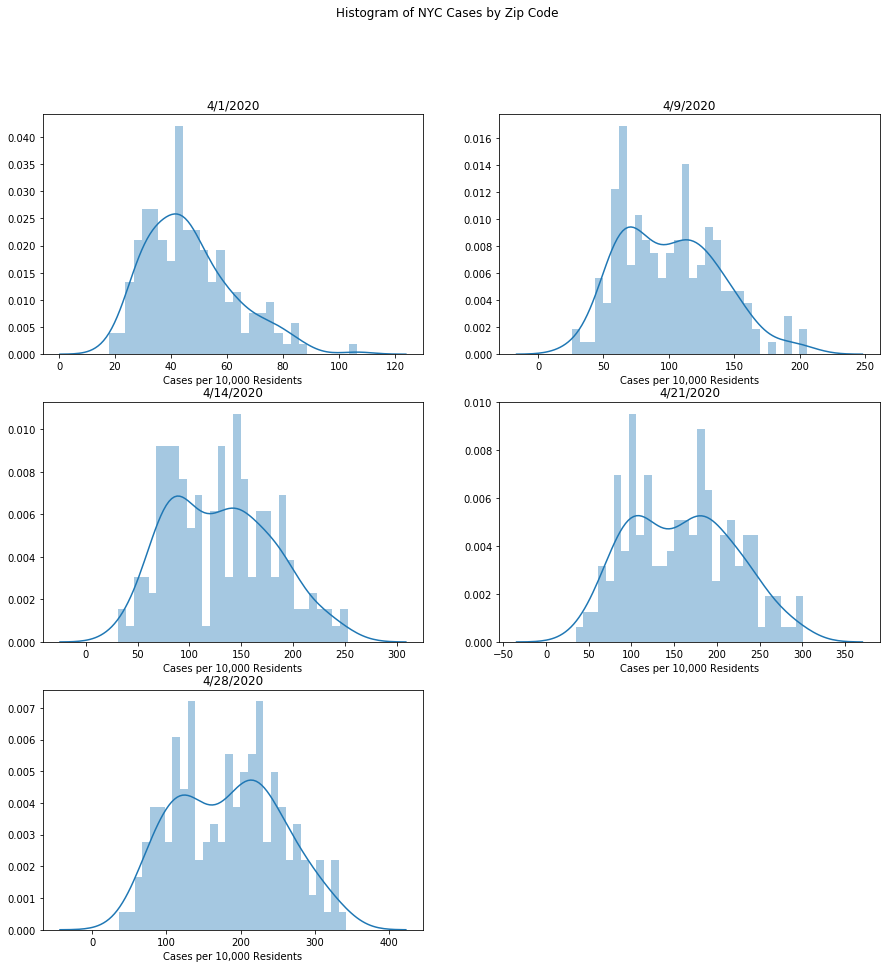

In [23]:
#Visualize the distribution of cases by zip
plt.figure(figsize = (15,15))
plt.suptitle("Histogram of NYC Cases by Zip Code")

plt.subplot(3,2,1)
sns.distplot(cases_per_10k.cases_per_10k_0401, bins = 30)
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/1/2020")

plt.subplot(3,2,2)
sns.distplot(cases_per_10k.cases_per_10k_0409, bins = 30)
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/9/2020")

plt.subplot(3,2,3)
sns.distplot(cases_per_10k.cases_per_10k_0414, bins = 30)
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/14/2020")

plt.subplot(3,2,4)
sns.distplot(cases_per_10k.cases_per_10k_0421, bins = 30)
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/21/2020")

plt.subplot(3,2,5)
sns.distplot(cases_per_10k.cases_per_10k_0428, bins = 30)
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/28/2020")

plt.show();

We observe a distinct bimodal distribution. Notably, the modes spread farther apart over time. 

For 4/7/2020, our target date, we calculate the categories of cases per capita for the outcome variable for classifiers. We note from the distribution above that the "high" vs "low" risk area appears to occur around 75 cases per 10,000 residents.

In [24]:
y_categorical_0409 = np.zeros(len(cases_per_10k.cases_per_10k_0409))
y_categorical_0409 = y_categorical_0409.astype(str)

#Low
y_categorical_0409[cases_per_10k.cases_per_10k_0409 <= 85] = "Low"
#High
y_categorical_0409[cases_per_10k.cases_per_10k_0409 > 85] = "High"

pd.DataFrame(y_categorical_0409, columns = ['y']).groupby('y').size()

y
High    105
Low      72
dtype: int64

We will also investigate the presence of 3 clusters in the clustering analysis.

In [25]:
y_categorical_0409_3 = np.zeros(len(cases_per_10k.cases_per_10k_0409))
y_categorical_0409_3 = y_categorical_0409_3.astype(str)

#Low
y_categorical_0409_3[cases_per_10k.cases_per_10k_0409 <= 75] = "Low"
#Medium
y_categorical_0409_3[(cases_per_10k.cases_per_10k_0409 > 75) & (cases_per_10k.cases_per_10k_0409 <= 110)] = "Medium"
#High
y_categorical_0409_3[cases_per_10k.cases_per_10k_0409 > 110] = "High"

pd.DataFrame(y_categorical_0409_3, columns = ['y']).groupby('y').size()

y
High      73
Low       53
Medium    51
dtype: int64

## Clustering Analysis

### PCA and Preliminary Cluster Visualization

The bimodal distribution certainly seems to indicate that not all of these cases are coming from the same distribution and there are underlying factors that are differentiating these observations.

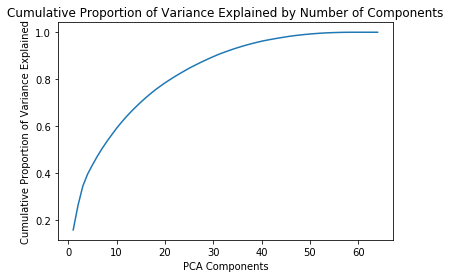

In [26]:
#Fit PCA
pca = PCA().fit(X)
X_pca = PCA().fit_transform(X)

#Plot Variance explained
plt.plot(list(range(1,len(pca.explained_variance_ratio_) + 1)), np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Proportion of Variance Explained by Number of Components")
plt.xlabel("PCA Components")
plt.ylabel("Cumulative Proportion of Variance Explained")
plt.show();

Even when looking just at the first two Principle Components, we can see clear clusters forming. These align quite clearly with the disease burden categories that we have identified.

### K Means - Raw Data

In [54]:
kmeans_fit_2 = KMeans(n_clusters = 2, n_init = 10, init = 'random', random_state = 0).fit(X)
kmeans_fit_3 = KMeans(n_clusters = 3, n_init = 10, init = 'random', random_state = 0).fit(X)

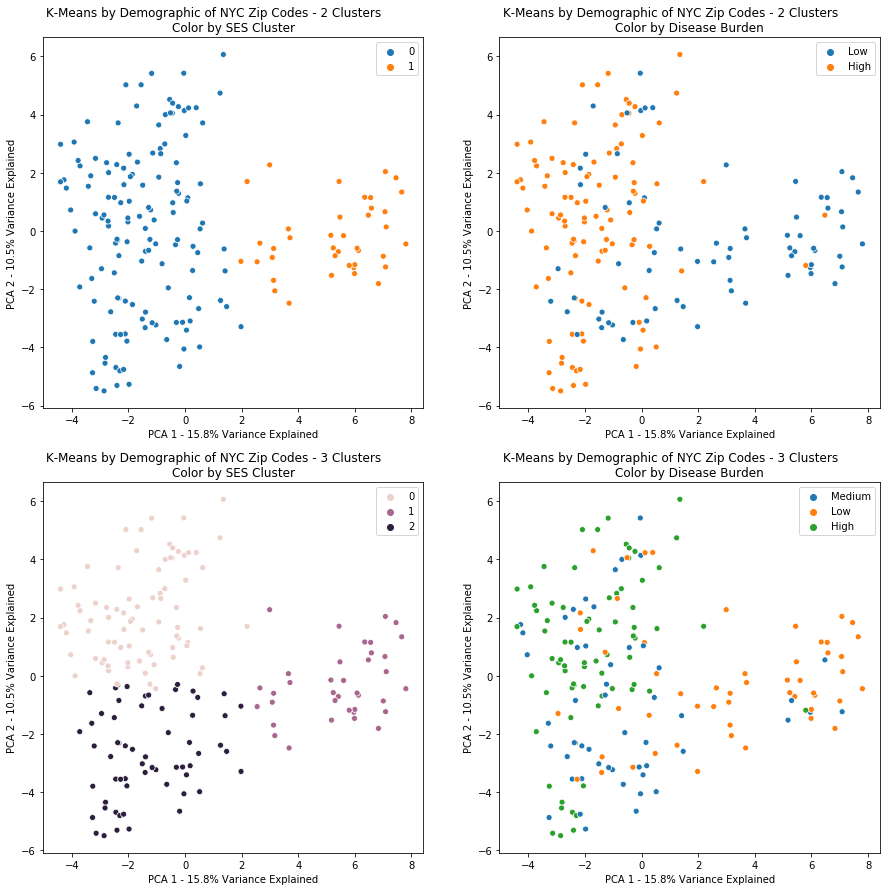

In [40]:
#Plot K Means
plt.figure(figsize = (15,15))
plt.subplot(2,2,1)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = kmeans_fit_2.labels_)
plt.title("K-Means by Demographic of NYC Zip Codes - 2 Clusters\
          \nColor by SES Cluster")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")

plt.subplot(2,2,2)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = y_categorical_0409)
plt.title("K-Means by Demographic of NYC Zip Codes - 2 Clusters\
          \nColor by Disease Burden")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")

plt.subplot(2,2,3)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = kmeans_fit_3.labels_)
plt.title("K-Means by Demographic of NYC Zip Codes - 3 Clusters\
          \nColor by SES Cluster")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")

plt.subplot(2,2,4)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = y_categorical_0409_3)
plt.title("K-Means by Demographic of NYC Zip Codes - 3 Clusters\
          \nColor by Disease Burden")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")

plt.show();

In [55]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, cluster_labels, clusterer, pointlabels=None):
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(5,5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette analysis for KMeans clustering on sample data")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


For n_clusters = 2, the average silhouette_score is 0.15698431663200013.


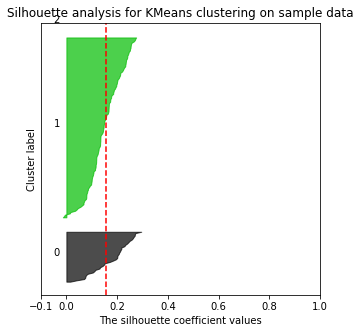

In [56]:
silplot(X, kmeans_fit_2.labels_, kmeans_fit_2, pointlabels=None)

For n_clusters = 3, the average silhouette_score is 0.11024537091017984.


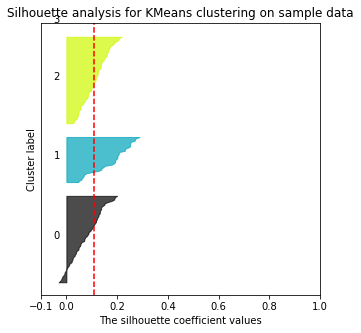

In [57]:
silplot(X, kmeans_fit_3.labels_, kmeans_fit_3, pointlabels=None)

The silhouette for n = 2 looks significantly better than the silhouette for n = 3. The average silhouette score is 0.195 vs 0.095.

### K Means - After PCA covering 95% of the variance

In [44]:
np.cumsum(pca.explained_variance_ratio_)

array([0.15814218, 0.26340121, 0.34537396, 0.39665957, 0.43552636,
       0.47203798, 0.50533181, 0.53574625, 0.563979  , 0.59158796,
       0.61675639, 0.64035065, 0.66214178, 0.68265006, 0.70233769,
       0.72076449, 0.73824876, 0.75484548, 0.76984736, 0.78443439,
       0.79782127, 0.81083594, 0.82319527, 0.83506054, 0.84675789,
       0.85727751, 0.8675895 , 0.87746905, 0.88709446, 0.89611479,
       0.90496657, 0.91281362, 0.92024593, 0.92739631, 0.93409114,
       0.94042354, 0.94630019, 0.95176647, 0.95689147, 0.96178549,
       0.96594653, 0.96983425, 0.97343732, 0.9769029 , 0.98023998,
       0.98346635, 0.98602842, 0.98834387, 0.99060963, 0.99241291,
       0.99411185, 0.99566007, 0.99691566, 0.9978401 , 0.99858337,
       0.99920865, 0.99968766, 0.99987963, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [64]:
kmeans_fit_2_PCA = KMeans(n_clusters = 2, n_init = 10, init = 'random', random_state = 0).fit(X_pca[:,:30])
kmeans_fit_3_PCA = KMeans(n_clusters = 3, n_init = 10, init = 'random', random_state = 0).fit(X_pca[:,:30])

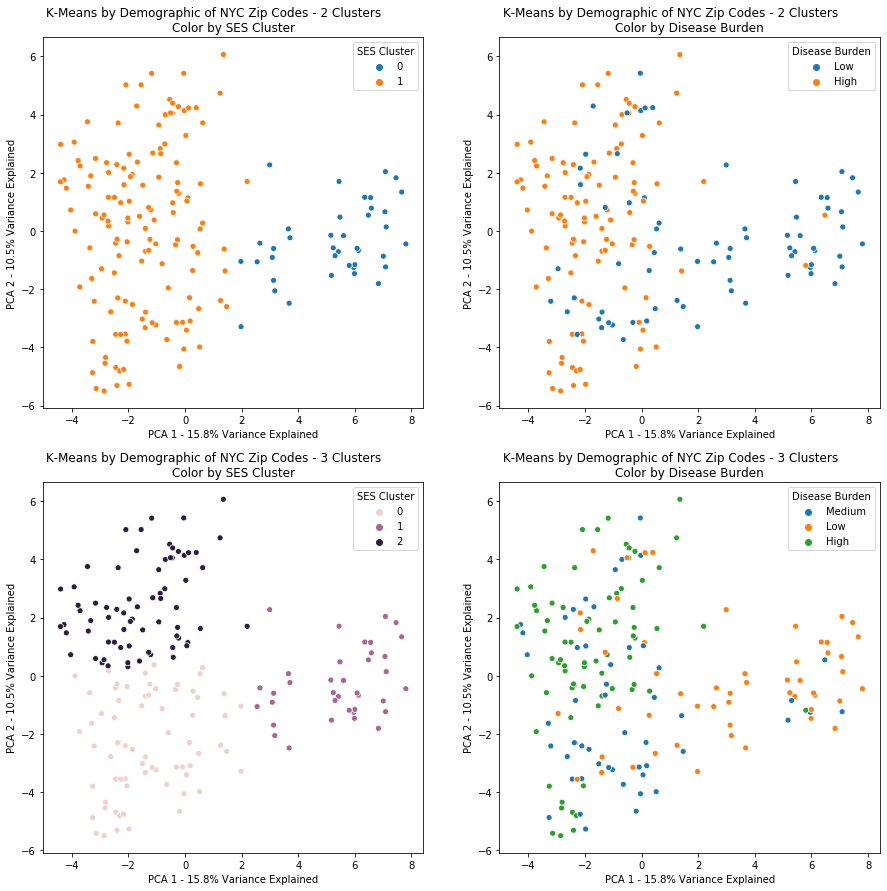

In [60]:
#Plot K Means
plt.figure(figsize = (15,15))
plt.subplot(2,2,1)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = kmeans_fit_2_PCA.labels_)
plt.title("K-Means by Demographic of NYC Zip Codes - 2 Clusters\
          \nColor by SES Cluster")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")
plt.legend(title = "SES Cluster")

plt.subplot(2,2,2)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = y_categorical_0409)
plt.title("K-Means by Demographic of NYC Zip Codes - 2 Clusters\
          \nColor by Disease Burden")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")
plt.legend(title = "Disease Burden")

plt.subplot(2,2,3)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = kmeans_fit_3_PCA.labels_)
plt.title("K-Means by Demographic of NYC Zip Codes - 3 Clusters\
          \nColor by SES Cluster")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")
plt.legend(title = "SES Cluster")

plt.subplot(2,2,4)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = y_categorical_0409_3)
plt.title("K-Means by Demographic of NYC Zip Codes - 3 Clusters\
          \nColor by Disease Burden")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")
plt.legend(title = "Disease Burden")

plt.show();

For n_clusters = 2, the average silhouette_score is 0.1724920427649748.


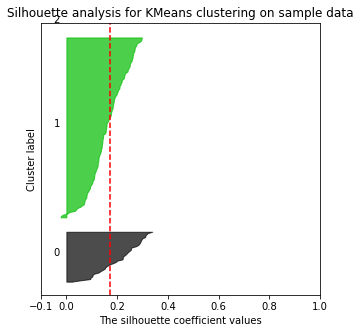

In [66]:
silplot(X_pca[:,:30], kmeans_fit_2_PCA.labels_, kmeans_fit_2_PCA, pointlabels=None)

For n_clusters = 3, the average silhouette_score is 0.1262821588175884.


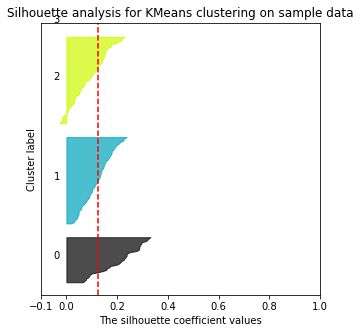

In [65]:
silplot(X_pca[:,:30], kmeans_fit_3_PCA.labels_, kmeans_fit_3_PCA, pointlabels=None)

Removing outliers through PCA has the result of discerning the cluster in the upper left hand side slightly better when n_clusters = 3, although the silhouette score is still lower for those categories compared to n_clusters = 2.

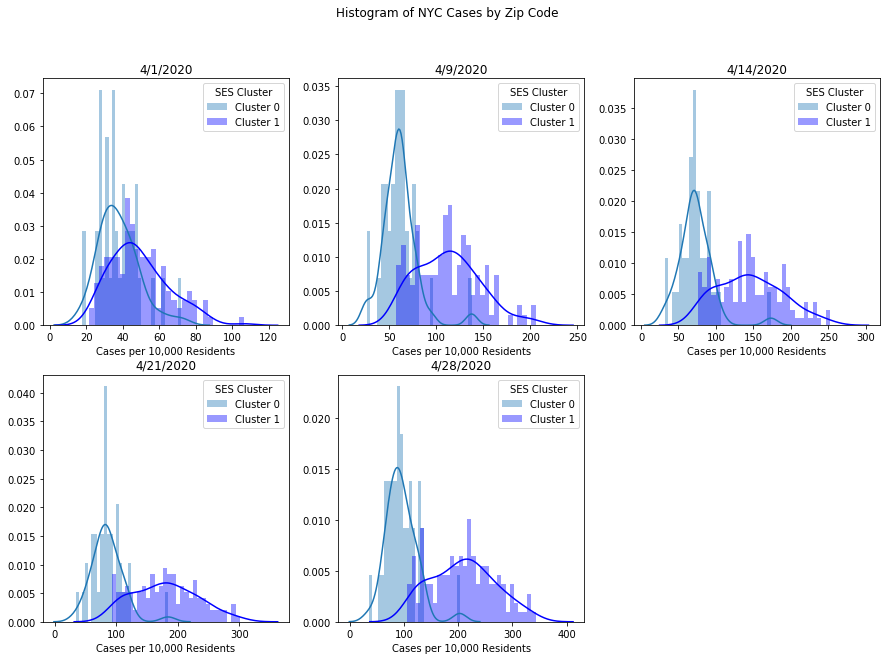

In [74]:
#Visualize the distribution of cases by zip and cluster
plt.figure(figsize = (15,10))
plt.suptitle("Histogram of NYC Cases by Zip Code")

plt.subplot(2,3,1)
sns.distplot(cases_per_10k.cases_per_10k_0401[kmeans_fit_2_PCA.labels_ == 0], bins = 30, label = 'Cluster 0')
sns.distplot(cases_per_10k.cases_per_10k_0401[kmeans_fit_2_PCA.labels_ == 1], bins = 30, color = 'blue', label = 'Cluster 1')
plt.legend(title = "SES Cluster")
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/1/2020")


plt.subplot(2,3,2)
sns.distplot(cases_per_10k.cases_per_10k_0409[kmeans_fit_2_PCA.labels_ == 0], bins = 30, label = 'Cluster 0')
sns.distplot(cases_per_10k.cases_per_10k_0409[kmeans_fit_2_PCA.labels_ == 1], bins = 30, color = 'blue', label = 'Cluster 1')
plt.legend(title = "SES Cluster")
plt.xlabel("Cases per 10,000 Residents")
# plt.axvline(x = 85)
plt.title("4/9/2020")

plt.subplot(2,3,3)
sns.distplot(cases_per_10k.cases_per_10k_0414[kmeans_fit_2_PCA.labels_ == 0], bins = 30, label = 'Cluster 0')
sns.distplot(cases_per_10k.cases_per_10k_0414[kmeans_fit_2_PCA.labels_ == 1], bins = 30, color = 'blue', label = 'Cluster 1')
plt.legend(title = "SES Cluster")
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/14/2020")

plt.subplot(2,3,4)
sns.distplot(cases_per_10k.cases_per_10k_0421[kmeans_fit_2_PCA.labels_ == 0], bins = 30, label = 'Cluster 0')
sns.distplot(cases_per_10k.cases_per_10k_0421[kmeans_fit_2_PCA.labels_ == 1], bins = 30, color = 'blue', label = 'Cluster 1')
plt.legend(title = "SES Cluster")
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/21/2020")

plt.subplot(2,3,5)
sns.distplot(cases_per_10k.cases_per_10k_0428[kmeans_fit_2_PCA.labels_ == 0], bins = 30, label = 'Cluster 0')
sns.distplot(cases_per_10k.cases_per_10k_0428[kmeans_fit_2_PCA.labels_ == 1], bins = 30, color = 'blue', label = 'Cluster 1')
plt.legend(title = "SES Cluster")
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/28/2020")

plt.show();



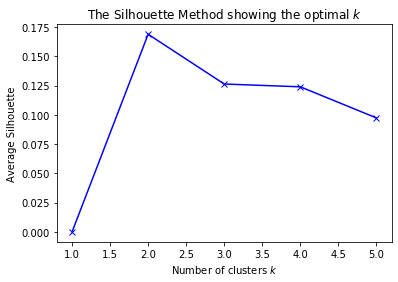

In [69]:
scores = [0]
for i in range(2,6):
    fitx = KMeans(n_clusters=i, init='k-means++', n_init=5, random_state=0).fit(X_pca[:,:30])
    score = silhouette_score(X_pca[:,:30], fitx.labels_)
    scores.append(score)
    
# plt.figure(figsize=(11,8.5))
plt.plot(range(1,6), np.array(scores), 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Average Silhouette')
plt.title('The Silhouette Method showing the optimal $k$')
plt.show();

In [81]:
y_categorical_0428 = np.zeros(len(cases_per_10k.cases_per_10k_0428))
y_categorical_0428 = y_categorical_0428.astype(str)

#Low
y_categorical_0428[cases_per_10k.cases_per_10k_0428 <= 150] = "Low"
#High
y_categorical_0428[cases_per_10k.cases_per_10k_0428 > 150] = "High"

pd.DataFrame(y_categorical_0428, columns = ['y']).groupby('y').size()

y
High    112
Low      65
dtype: int64

In [82]:
rf = RandomForestClassifier(n_estimators = 100, oob_score = True, random_state = 123).fit(X, y_categorical_0428)
rf.oob_score_

0.8531073446327684

## Lasso

In [83]:
Cs = np.logspace(-5, 5, 100)
tuned_parameters = [{'C': Cs}]
n_folds = 5

clf = GridSearchCV(LogisticRegression(random_state=0, tol = 0.1, solver = 'liblinear',penalty='l1'), tuned_parameters, 
                   cv=n_folds, refit=False, scoring = 'accuracy')
clf.fit(pd.DataFrame(X, columns = X_cols), y_categorical_0409)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l1',
                                          random_state=0, solver='liblinear',
                                          tol=0.1, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': array([1.00000000e-05, 1.26...
       1.20450354e+03, 1.51991108e+03, 1.91791026e+03, 2.42012826e+03,
       3.05385551e+03, 3.85352859e+03, 4.86260158e+03, 6.13590727e+03,
       7.74263683e+03, 9.77009957e+03, 1.23284674e+04, 1.55567614e+04,
       1.96304065e+04, 2.47707636e+04, 3.12571585e+04, 3.94420606e+04,
       4

In [84]:
scores_logistic = clf.cv_results_['mean_test_score']
scores_std_logistic = clf.cv_results_['std_test_score']
clf.cv_results_["mean_test_score"]
best_C = list(clf.best_params_.values())
print("Best C is: " + str(best_C))

Best C is: [0.04328761281083057]


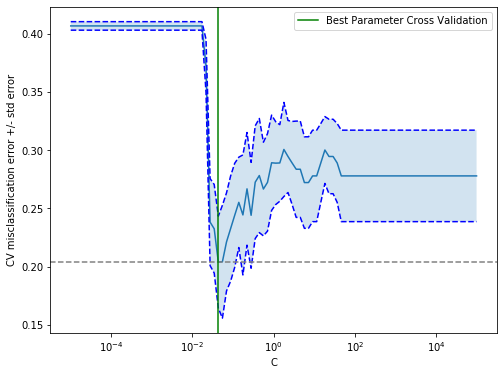

In [85]:
plt.figure().set_size_inches(8, 6)
plt.semilogx(Cs, 1 - scores_logistic)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std_logistic / np.sqrt(n_folds)

plt.semilogx(Cs, 1 - scores_logistic + std_error, 'b--')
plt.semilogx(Cs, 1 - scores_logistic - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(Cs, 1 - scores_logistic + std_error, 1 - scores_logistic - std_error, alpha=0.2)

plt.ylabel('CV misclassification error +/- std error')
plt.xlabel('C')
plt.axhline(np.min(1-scores_logistic), linestyle='--', color='.5')
plt.axvline(x = best_C, color = "g", label = "Best Parameter Cross Validation")
plt.legend(loc = "best")

plt.show();

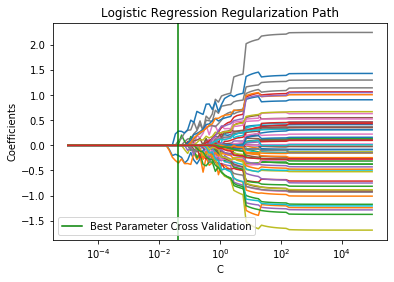

In [86]:
#cs = l1_min_c(X, y, loss='log') * np.logspace(-1, 5, 100)
cs = np.logspace(-5, 5, 100)

clf = LogisticRegression(penalty='l1', solver='liblinear',
                                      tol=0.1, 
                                      warm_start=True,
                                      random_state=0)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(pd.DataFrame(X, columns = X_cols), y_categorical_0409)
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = np.array(coefs_)
plt.plot(cs, coefs_)
plt.semilogx()
ymin, ymax = plt.ylim()
plt.xlabel('C')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Regularization Path')
plt.axis('tight')

plt.axvline(x = best_C, color = "g", label = "Best Parameter Cross Validation")
plt.legend(loc = "lower left")

plt.show();

In [105]:
best_lasso = LogisticRegression(penalty='l1', solver='liblinear',
                                      tol=0.1, 
                                      warm_start=True,
                                      random_state=0, C = float(best_C[0]))

X_lasso_train = X[:140]
X_lasso_test = X[140:]
y_categorical_0409_train = y_categorical_0409[:140]
y_categorical_0409_test = y_categorical_0409[140:]

In [106]:
best_lasso.fit(pd.DataFrame(X_lasso_train, columns = X_cols), y_categorical_0409_train)

LogisticRegression(C=0.04328761281083057, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=0, solver='liblinear', tol=0.1, verbose=0,
                   warm_start=True)

In [107]:
print("Min Logistic Score: " + str(best_lasso.score(pd.DataFrame(X, columns = X_cols), y_categorical_0409)))

Min Logistic Score: 0.8022598870056498


Take a look at misclassification rates:

In [139]:
lasso_predictions = best_lasso.predict(X_lasso_test)
len(lasso_predictions[lasso_predictions != y_categorical_0409_test]) / len(y_categorical_0409_test)

0.7027027027027027

Non-zero lasso features

In [140]:
lasso_feature_imp = pd.Series(best_lasso.coef_[0],index=X_cols.tolist()).sort_values(ascending=False)
lasso_feature_imp[lasso_feature_imp != 0]

beds                       0.115850
Housing Units             -0.111826
Median Household Income   -0.364970
dtype: float64

In [136]:
#np.sum(best_lasso.predict(X) != y_categorical_0409) / len(y_categorical_0409)

In [137]:
# y_categorical_0409[best_lasso.predict(X) != y_categorical_0409]

In [138]:
# pd.DataFrame(X, columns = X_cols)[best_lasso.predict(X) != y_categorical_0409]
# data[best_lasso.predict(X) != y_categorical_0409]

## Random Forest

In [92]:
#Low
y_categorical_0409[cases_per_10k.cases_per_10k_0409 <= 85] = "Low"
#High
y_categorical_0409[cases_per_10k.cases_per_10k_0409 > 85] = "High"

In [93]:
data['y_categorical']= y_categorical_0409

In [94]:
y=data['y_categorical']

In [95]:
data.groupby('y_categorical').size()

y_categorical
High    105
Low      72
dtype: int64

In [96]:
X.shape

(177, 64)

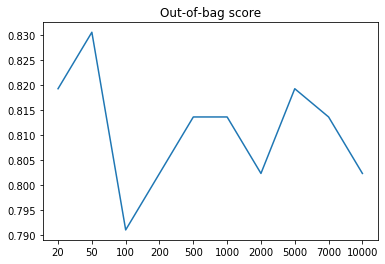

In [97]:
Bs = [20,50,100,200,500,1000, 2000, 5000, 7000, 10000]
OOBs = []
for B in Bs:
    fit_hpys = RandomForestClassifier(n_estimators=B, oob_score = True, random_state=263)
    fit_hpys.fit(X,y)
    OOBs.append(fit_hpys.oob_score_)

plt.plot(list(map(str,Bs)),OOBs)
plt.title("Out-of-bag score")
plt.show();

In [98]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=50, oob_score = True, random_state=263)

In [99]:
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=True, random_state=263, verbose=0,
                       warm_start=False)

In [100]:
clf.oob_score_

0.8305084745762712

In [115]:
feature_imp = pd.Series(clf.feature_importances_,index=X_cols.tolist()).sort_values(ascending=False)
feature_imp.head(20)

Percent of Population with High School Education                0.078399
Percent of Population Transporting to Work in Car               0.072046
Perent of Population with Some College Education                0.054239
Percent of Population Transporting to Work on Bike              0.053537
Percent of Population with Bachelors Degree                     0.053279
Percent of Population that Works at Home                        0.037579
Average Number of Vechicles                                     0.033625
Percent of Population with Masters Degree or Higher             0.033525
Percent of Population under High School Education               0.028158
pop_perc_asian                                                  0.026115
Median Household Income                                         0.024799
Percent of Population Transporting to work in Public Transit    0.024479
Percent of Population that Walks to Work                        0.023033
Percent of Population on Social Security Income    

No handles with labels found to put in legend.


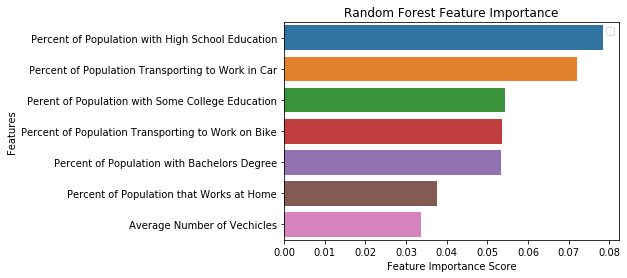

In [102]:
#Plotting Feature importance
sns.barplot(x=feature_imp[0:7], y=feature_imp.index[0:7])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Random Forest Feature Importance")
plt.legend()
plt.show()

## Lasso

In [103]:
X_cols

Index(['Median Household Income', 'Housing Units', 'pop_total', 'Median Age',
       'Percent of Population White', 'Percent of Popuation Black',
       'Percent of Population Indian Alaskan', 'pop_perc_asian',
       'Percent of Population Other Race',
       'Percent of Population under High School Education',
       'Percent of Population with High School Education',
       'Perent of Population with Some College Education',
       'Percent of Population with Bachelors Degree',
       'Percent of Population with Masters Degree or Higher',
       'Percent of Population US Citizens',
       'Percent of Population Transporting to Work in Car',
       'Percent of Population Transporting to work in Public Transit',
       'Percent of Population Transporting to Work on Bike',
       'Percent of Population that Walks to Work',
       'Percent of Population that Transports to work via Taxi',
       'Percent of Population that Works at Home',
       'Percent of Population that Works in State